In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatboostIpythonWidget

## Examine data

In [2]:
%%capture
df = pd.read_csv('clinvar_20180225.ann.tsv.gz', compression='gzip', sep='\t', error_bad_lines=False, header=0)

In [3]:
len(df)

372159

In [4]:
df.head()

,#id,chrom,inputPos,inputRef,inputAlt,unannotatedReason,gene,geneId,geneDesc,transcript,...,granthamDist,AGVGDclass,AGVGDgv,AGVGDgd,SIFTprediction,SIFTweight,SIFTmedian,MAPPprediction,MAPPpValue,MAPPpValueMedian
0,475283,1,949422,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,178.468,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,183381,1,949523,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,475278,1,949597,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,402986,1,949608,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,130.977,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,161455,1,949696,C,CG,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

#id                       int64
chrom                    object
inputPos                  int64
inputRef                 object
inputAlt                 object
unannotatedReason        object
gene                     object
geneId                    int64
geneDesc                 object
transcript               object
strand                    int64
transLen                  int64
cdsLen                    int64
protein                  object
Uniprot                  object
varType                  object
codingEffect             object
varLocation              object
assembly                 object
gDNAstart                 int64
gDNAend                   int64
gNomen                   object
cDNAstart                object
cDNAend                  object
cNomen                   object
pNomen                   object
alt_pNomen               object
exon                      int64
intron                  float64
omimId                  float64
                         ...   
wtAA_3  

In [6]:
df.isnull().sum()

#id                          0
chrom                        0
inputPos                     0
inputRef                     0
inputAlt                     0
unannotatedReason            0
gene                         0
geneId                       0
geneDesc                     0
transcript                   0
strand                       0
transLen                     0
cdsLen                       0
protein                  16608
Uniprot                  88433
varType                      0
codingEffect            131716
varLocation                  0
assembly                     0
gDNAstart                    0
gDNAend                      0
gNomen                       0
cDNAstart                    0
cDNAend                      0
cNomen                       0
pNomen                    2380
alt_pNomen                2380
exon                         0
intron                  318115
omimId                   21182
                         ...  
wtAA_3                  158696
wtCodon 

## Preprocessing

### Filters

In [7]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
]


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df


df = df[RELEVANT_FEATURES]  # Filtering relevant features
df = rules_filter(df)  # Rules filtering
df.reset_index(drop=True, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,varMaxEntScore,rsMAF,1000g_AF,gnomadAltFreq_all,espAllMAF,espAllAAF,clinVarMethods,clinVarClinSignifs,nOrthos,conservedOrthos
0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,7.04863,0.006190,0.006190,0.001599,0.005459,0.005459,NaN,NaN,10.0,2.0
1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
2,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
3,1,949739,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,7.04863,0.000000,NaN,0.000008,NaN,NaN,literature only,Pathogenic,NaN,NaN
4,1,949851,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,7.04863,0.000799,0.000799,0.000265,0.000698,0.000698,NaN,NaN,10.0,2.0


### `inputPos` as regression parametr

In [8]:
df.inputPos = df.inputPos.astype(float)

### `clinVarMethods` split

In [9]:
def fetch_names(row, delimeters='|,'):
    def unify(name):
        return '_'.join(name.strip().lower().split())
    
    names = [row]
    for delimeter in delimeters:
        new_names = []
        for name in names:
            new_names.extend(name.split(delimeter))
        names = new_names
    return [unify(name) for name in names]


def collect_names(column, delimeters='|,'): 
    all_names = set()
    for row in column:
        all_names.update(set(fetch_names(row)))
    return all_names

In [10]:
df.clinVarMethods = df.clinVarMethods.fillna('NaN')
cvm_methods = {m: i for i, m in enumerate(list(collect_names(df.clinVarMethods)))}
cvm_features = []
for row in df.clinVarMethods:
    row_features = np.zeros(len(cvm_methods))
    for name in fetch_names(row):
        row_features[cvm_methods[name]] += 1
    cvm_features.append(row_features)
cvm_features = np.vstack(cvm_features)

cvm_columns = ['cvm_' + m for _, m in sorted([(i, m) for m, i in cvm_methods.items()])]
cvm_features = pd.DataFrame(cvm_features, columns=cvm_columns)
df = pd.concat([df, cvm_features], axis=1)
del df['clinVarMethods']
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_in_vitro,cvm_phenotyping_only,cvm_not_provided,cvm_literature_only,cvm_provider_interpretation,cvm_clinical_testing,cvm_nan,cvm_research,cvm_reference_population,cvm_curation
0,1,949422.0,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,949851.0,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Making target

In [11]:
def binarize_target(y, bad_word='pathogenic'):
    return y.apply(lambda x: int(bad_word in x.lower()))

In [12]:
df = df.loc[df.clinVarClinSignifs.notna()]
df.reset_index(drop=True, inplace=True)
df.rename({'clinVarClinSignifs': 'y'}, axis=1, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_in_vitro,cvm_phenotyping_only,cvm_not_provided,cvm_literature_only,cvm_provider_interpretation,cvm_clinical_testing,cvm_nan,cvm_research,cvm_reference_population,cvm_curation
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## TT split

In [13]:
def tt_split(df):
    np.random.seed(42)
    df = df.copy()
    
    y = binarize_target(df.y)
    del df['y']
    X = df
    
    X = X.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
    
    cat_features = np.where(X.dtypes != np.float)[0]

    return (X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features

## NDCG

In [14]:
relevances = {'benign': 0, 'likely benign': 1, 'not provided': 2, 'vus': 2, 'likely pathogenic': 3, 'pathogenic': 4}


def split_relevance(relevance):
    return [r.lower() for it in relevance.split('|') for r in it.split(', ') if r.lower() in relevances]


def get_relevances(significances):
    return [split_relevance(significance) for significance in significances.values]


def dcg(relevances):
    return np.sum(2 ** relevances / np.log2(np.arange(2, relevances.size + 2)))


def evaluate_serp(df, sign, score, n=30):
    serp = df.sample(n=n, replace=False)
    rel_true = np.array([relevances[np.random.choice(sign[index], size=1)[0]] for index, row in serp.iterrows()])

    order_true = np.argsort(rel_true)[::-1]
    serp = serp.iloc[order_true]
    rel_true = rel_true[order_true]

    order_pred = np.argsort(score[serp.index])[::-1]
    rel_pred = rel_true[order_pred]
    
    return dcg(rel_pred) / dcg(rel_true)


def evaluate(df, sign, score, k=1000, n=30):
    np.random.seed(42)
    return np.mean([evaluate_serp(df, sign, score, n) for _ in range(k)])

In [15]:
sign = pd.Series(data=get_relevances(df.y), index=df.index)
not_empty = [it != [] for it in sign]
df = df[not_empty]
sign = sign[not_empty]
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_in_vitro,cvm_phenotyping_only,cvm_not_provided,cvm_literature_only,cvm_provider_interpretation,cvm_clinical_testing,cvm_nan,cvm_research,cvm_reference_population,cvm_curation
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Run

In [16]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features = tt_split(df)
len(X_train), len(X_validate), len(X_test)

(126179, 31545, 39431)

In [17]:
model = CatBoostClassifier()

In [18]:
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_validate, y_validate),
          plot=False);

0:	learn: 0.6637257	test: 0.6635146	best: 0.6635146 (0)	total: 382ms	remaining: 6m 21s
1:	learn: 0.6366080	test: 0.6361923	best: 0.6361923 (1)	total: 710ms	remaining: 5m 54s
2:	learn: 0.6108866	test: 0.6104289	best: 0.6104289 (2)	total: 1.08s	remaining: 5m 57s
3:	learn: 0.5890402	test: 0.5883349	best: 0.5883349 (3)	total: 1.59s	remaining: 6m 35s
4:	learn: 0.5676031	test: 0.5667099	best: 0.5667099 (4)	total: 2.1s	remaining: 6m 57s
5:	learn: 0.5436980	test: 0.5425079	best: 0.5425079 (5)	total: 2.63s	remaining: 7m 16s
6:	learn: 0.5219954	test: 0.5203940	best: 0.5203940 (6)	total: 2.93s	remaining: 6m 55s
7:	learn: 0.5017883	test: 0.4995640	best: 0.4995640 (7)	total: 3.32s	remaining: 6m 51s
8:	learn: 0.4831081	test: 0.4804146	best: 0.4804146 (8)	total: 3.73s	remaining: 6m 50s
9:	learn: 0.4670837	test: 0.4637498	best: 0.4637498 (9)	total: 4.04s	remaining: 6m 39s
10:	learn: 0.4513924	test: 0.4476355	best: 0.4476355 (10)	total: 4.31s	remaining: 6m 27s
11:	learn: 0.4373930	test: 0.4331708	best:

93:	learn: 0.2166563	test: 0.2055934	best: 0.2055934 (93)	total: 32.8s	remaining: 5m 16s
94:	learn: 0.2162860	test: 0.2052785	best: 0.2052785 (94)	total: 33.8s	remaining: 5m 22s
95:	learn: 0.2159543	test: 0.2049448	best: 0.2049448 (95)	total: 34.3s	remaining: 5m 23s
96:	learn: 0.2154097	test: 0.2043938	best: 0.2043938 (96)	total: 34.8s	remaining: 5m 23s
97:	learn: 0.2149647	test: 0.2039410	best: 0.2039410 (97)	total: 35.3s	remaining: 5m 24s
98:	learn: 0.2142819	test: 0.2032909	best: 0.2032909 (98)	total: 35.8s	remaining: 5m 25s
99:	learn: 0.2138909	test: 0.2029344	best: 0.2029344 (99)	total: 36.5s	remaining: 5m 28s
100:	learn: 0.2136467	test: 0.2026962	best: 0.2026962 (100)	total: 36.8s	remaining: 5m 27s
101:	learn: 0.2132976	test: 0.2023269	best: 0.2023269 (101)	total: 37.1s	remaining: 5m 26s
102:	learn: 0.2130013	test: 0.2020516	best: 0.2020516 (102)	total: 37.4s	remaining: 5m 25s
103:	learn: 0.2127030	test: 0.2017792	best: 0.2017792 (103)	total: 37.7s	remaining: 5m 24s
104:	learn: 0

184:	learn: 0.1950248	test: 0.1851297	best: 0.1851297 (184)	total: 1m 3s	remaining: 4m 41s
185:	learn: 0.1948855	test: 0.1850154	best: 0.1850154 (185)	total: 1m 4s	remaining: 4m 40s
186:	learn: 0.1946877	test: 0.1848432	best: 0.1848432 (186)	total: 1m 4s	remaining: 4m 41s
187:	learn: 0.1945719	test: 0.1847521	best: 0.1847521 (187)	total: 1m 5s	remaining: 4m 41s
188:	learn: 0.1944580	test: 0.1846313	best: 0.1846313 (188)	total: 1m 5s	remaining: 4m 41s
189:	learn: 0.1942520	test: 0.1844425	best: 0.1844425 (189)	total: 1m 5s	remaining: 4m 41s
190:	learn: 0.1941345	test: 0.1843448	best: 0.1843448 (190)	total: 1m 6s	remaining: 4m 40s
191:	learn: 0.1940130	test: 0.1842542	best: 0.1842542 (191)	total: 1m 6s	remaining: 4m 40s
192:	learn: 0.1939606	test: 0.1842178	best: 0.1842178 (192)	total: 1m 7s	remaining: 4m 41s
193:	learn: 0.1939159	test: 0.1841729	best: 0.1841729 (193)	total: 1m 8s	remaining: 4m 43s
194:	learn: 0.1937659	test: 0.1840362	best: 0.1840362 (194)	total: 1m 8s	remaining: 4m 43s

274:	learn: 0.1862817	test: 0.1773864	best: 0.1773864 (274)	total: 1m 38s	remaining: 4m 20s
275:	learn: 0.1861503	test: 0.1772739	best: 0.1772739 (275)	total: 1m 39s	remaining: 4m 20s
276:	learn: 0.1860674	test: 0.1772122	best: 0.1772122 (276)	total: 1m 39s	remaining: 4m 19s
277:	learn: 0.1860238	test: 0.1771692	best: 0.1771692 (277)	total: 1m 39s	remaining: 4m 19s
278:	learn: 0.1859251	test: 0.1771012	best: 0.1771012 (278)	total: 1m 40s	remaining: 4m 19s
279:	learn: 0.1859061	test: 0.1770911	best: 0.1770911 (279)	total: 1m 40s	remaining: 4m 18s
280:	learn: 0.1858075	test: 0.1769987	best: 0.1769987 (280)	total: 1m 40s	remaining: 4m 18s
281:	learn: 0.1857727	test: 0.1769780	best: 0.1769780 (281)	total: 1m 41s	remaining: 4m 17s
282:	learn: 0.1857390	test: 0.1769384	best: 0.1769384 (282)	total: 1m 41s	remaining: 4m 17s
283:	learn: 0.1856988	test: 0.1768765	best: 0.1768765 (283)	total: 1m 41s	remaining: 4m 16s
284:	learn: 0.1856570	test: 0.1768528	best: 0.1768528 (284)	total: 1m 42s	remain

364:	learn: 0.1814134	test: 0.1733575	best: 0.1733575 (364)	total: 2m 12s	remaining: 3m 49s
365:	learn: 0.1813448	test: 0.1733083	best: 0.1733083 (365)	total: 2m 12s	remaining: 3m 49s
366:	learn: 0.1813103	test: 0.1732911	best: 0.1732911 (366)	total: 2m 12s	remaining: 3m 49s
367:	learn: 0.1812783	test: 0.1732773	best: 0.1732773 (367)	total: 2m 13s	remaining: 3m 48s
368:	learn: 0.1812347	test: 0.1732372	best: 0.1732372 (368)	total: 2m 13s	remaining: 3m 48s
369:	learn: 0.1812058	test: 0.1732206	best: 0.1732206 (369)	total: 2m 13s	remaining: 3m 47s
370:	learn: 0.1812006	test: 0.1732164	best: 0.1732164 (370)	total: 2m 14s	remaining: 3m 47s
371:	learn: 0.1811808	test: 0.1731977	best: 0.1731977 (371)	total: 2m 14s	remaining: 3m 46s
372:	learn: 0.1811672	test: 0.1731871	best: 0.1731871 (372)	total: 2m 14s	remaining: 3m 46s
373:	learn: 0.1811381	test: 0.1731665	best: 0.1731665 (373)	total: 2m 14s	remaining: 3m 45s
374:	learn: 0.1811129	test: 0.1731482	best: 0.1731482 (374)	total: 2m 15s	remain

454:	learn: 0.1783405	test: 0.1710701	best: 0.1710701 (454)	total: 2m 41s	remaining: 3m 13s
455:	learn: 0.1782851	test: 0.1710244	best: 0.1710244 (455)	total: 2m 41s	remaining: 3m 12s
456:	learn: 0.1782591	test: 0.1710174	best: 0.1710174 (456)	total: 2m 41s	remaining: 3m 12s
457:	learn: 0.1782391	test: 0.1709938	best: 0.1709938 (457)	total: 2m 42s	remaining: 3m 12s
458:	learn: 0.1781971	test: 0.1709581	best: 0.1709581 (458)	total: 2m 42s	remaining: 3m 11s
459:	learn: 0.1781727	test: 0.1709372	best: 0.1709372 (459)	total: 2m 42s	remaining: 3m 11s
460:	learn: 0.1780947	test: 0.1708728	best: 0.1708728 (460)	total: 2m 43s	remaining: 3m 10s
461:	learn: 0.1780780	test: 0.1708599	best: 0.1708599 (461)	total: 2m 43s	remaining: 3m 10s
462:	learn: 0.1780601	test: 0.1708498	best: 0.1708498 (462)	total: 2m 43s	remaining: 3m 9s
463:	learn: 0.1780379	test: 0.1708421	best: 0.1708421 (463)	total: 2m 44s	remaining: 3m 9s
464:	learn: 0.1780161	test: 0.1708352	best: 0.1708352 (464)	total: 2m 44s	remainin

544:	learn: 0.1755934	test: 0.1690609	best: 0.1690609 (544)	total: 3m 12s	remaining: 2m 41s
545:	learn: 0.1755217	test: 0.1690033	best: 0.1690033 (545)	total: 3m 13s	remaining: 2m 40s
546:	learn: 0.1755035	test: 0.1689995	best: 0.1689995 (546)	total: 3m 13s	remaining: 2m 40s
547:	learn: 0.1754778	test: 0.1689764	best: 0.1689764 (547)	total: 3m 14s	remaining: 2m 40s
548:	learn: 0.1754610	test: 0.1689692	best: 0.1689692 (548)	total: 3m 14s	remaining: 2m 39s
549:	learn: 0.1753935	test: 0.1689118	best: 0.1689118 (549)	total: 3m 14s	remaining: 2m 39s
550:	learn: 0.1753661	test: 0.1688970	best: 0.1688970 (550)	total: 3m 15s	remaining: 2m 39s
551:	learn: 0.1753368	test: 0.1688641	best: 0.1688641 (551)	total: 3m 15s	remaining: 2m 39s
552:	learn: 0.1753156	test: 0.1688566	best: 0.1688566 (552)	total: 3m 16s	remaining: 2m 38s
553:	learn: 0.1752246	test: 0.1687821	best: 0.1687821 (553)	total: 3m 16s	remaining: 2m 38s
554:	learn: 0.1751337	test: 0.1687011	best: 0.1687011 (554)	total: 3m 17s	remain

634:	learn: 0.1731991	test: 0.1674147	best: 0.1674147 (634)	total: 3m 44s	remaining: 2m 8s
635:	learn: 0.1731390	test: 0.1673585	best: 0.1673585 (635)	total: 3m 44s	remaining: 2m 8s
636:	learn: 0.1731045	test: 0.1673370	best: 0.1673370 (636)	total: 3m 44s	remaining: 2m 8s
637:	learn: 0.1730866	test: 0.1673316	best: 0.1673316 (637)	total: 3m 44s	remaining: 2m 7s
638:	learn: 0.1730706	test: 0.1673116	best: 0.1673116 (638)	total: 3m 45s	remaining: 2m 7s
639:	learn: 0.1730417	test: 0.1672812	best: 0.1672812 (639)	total: 3m 45s	remaining: 2m 6s
640:	learn: 0.1730317	test: 0.1672782	best: 0.1672782 (640)	total: 3m 45s	remaining: 2m 6s
641:	learn: 0.1730003	test: 0.1672371	best: 0.1672371 (641)	total: 3m 46s	remaining: 2m 6s
642:	learn: 0.1729875	test: 0.1672308	best: 0.1672308 (642)	total: 3m 46s	remaining: 2m 5s
643:	learn: 0.1729654	test: 0.1672239	best: 0.1672239 (643)	total: 3m 46s	remaining: 2m 5s
644:	learn: 0.1729385	test: 0.1672079	best: 0.1672079 (644)	total: 3m 46s	remaining: 2m 4s

724:	learn: 0.1712167	test: 0.1660290	best: 0.1660290 (724)	total: 4m 10s	remaining: 1m 34s
725:	learn: 0.1711670	test: 0.1659799	best: 0.1659799 (725)	total: 4m 10s	remaining: 1m 34s
726:	learn: 0.1711495	test: 0.1659806	best: 0.1659799 (725)	total: 4m 10s	remaining: 1m 34s
727:	learn: 0.1711462	test: 0.1659814	best: 0.1659799 (725)	total: 4m 11s	remaining: 1m 33s
728:	learn: 0.1711408	test: 0.1659796	best: 0.1659796 (728)	total: 4m 11s	remaining: 1m 33s
729:	learn: 0.1711140	test: 0.1659703	best: 0.1659703 (729)	total: 4m 11s	remaining: 1m 33s
730:	learn: 0.1711012	test: 0.1659702	best: 0.1659702 (730)	total: 4m 12s	remaining: 1m 32s
731:	learn: 0.1710906	test: 0.1659689	best: 0.1659689 (731)	total: 4m 12s	remaining: 1m 32s
732:	learn: 0.1710702	test: 0.1659634	best: 0.1659634 (732)	total: 4m 12s	remaining: 1m 32s
733:	learn: 0.1710633	test: 0.1659598	best: 0.1659598 (733)	total: 4m 12s	remaining: 1m 31s
734:	learn: 0.1710401	test: 0.1659443	best: 0.1659443 (734)	total: 4m 13s	remain

814:	learn: 0.1698096	test: 0.1652367	best: 0.1652367 (814)	total: 4m 36s	remaining: 1m 2s
815:	learn: 0.1698013	test: 0.1652354	best: 0.1652354 (815)	total: 4m 36s	remaining: 1m 2s
816:	learn: 0.1697969	test: 0.1652309	best: 0.1652309 (816)	total: 4m 37s	remaining: 1m 2s
817:	learn: 0.1697822	test: 0.1652254	best: 0.1652254 (817)	total: 4m 37s	remaining: 1m 1s
818:	learn: 0.1697586	test: 0.1652054	best: 0.1652054 (818)	total: 4m 37s	remaining: 1m 1s
819:	learn: 0.1697456	test: 0.1651854	best: 0.1651854 (819)	total: 4m 37s	remaining: 1m 1s
820:	learn: 0.1697220	test: 0.1651833	best: 0.1651833 (820)	total: 4m 38s	remaining: 1m
821:	learn: 0.1697094	test: 0.1651781	best: 0.1651781 (821)	total: 4m 38s	remaining: 1m
822:	learn: 0.1696844	test: 0.1651562	best: 0.1651562 (822)	total: 4m 38s	remaining: 60s
823:	learn: 0.1696811	test: 0.1651572	best: 0.1651562 (822)	total: 4m 39s	remaining: 59.6s
824:	learn: 0.1696652	test: 0.1651265	best: 0.1651265 (824)	total: 4m 39s	remaining: 59.3s
825:	le

905:	learn: 0.1685058	test: 0.1644382	best: 0.1644382 (905)	total: 5m 3s	remaining: 31.5s
906:	learn: 0.1685037	test: 0.1644362	best: 0.1644362 (906)	total: 5m 3s	remaining: 31.1s
907:	learn: 0.1684975	test: 0.1644366	best: 0.1644362 (906)	total: 5m 3s	remaining: 30.8s
908:	learn: 0.1684880	test: 0.1644282	best: 0.1644282 (908)	total: 5m 4s	remaining: 30.5s
909:	learn: 0.1684824	test: 0.1644275	best: 0.1644275 (909)	total: 5m 4s	remaining: 30.1s
910:	learn: 0.1684533	test: 0.1644042	best: 0.1644042 (910)	total: 5m 4s	remaining: 29.8s
911:	learn: 0.1684173	test: 0.1643581	best: 0.1643581 (911)	total: 5m 5s	remaining: 29.4s
912:	learn: 0.1684097	test: 0.1643583	best: 0.1643581 (911)	total: 5m 5s	remaining: 29.1s
913:	learn: 0.1683963	test: 0.1643548	best: 0.1643548 (913)	total: 5m 5s	remaining: 28.8s
914:	learn: 0.1683842	test: 0.1643522	best: 0.1643522 (914)	total: 5m 5s	remaining: 28.4s
915:	learn: 0.1683740	test: 0.1643533	best: 0.1643522 (914)	total: 5m 6s	remaining: 28.1s
916:	learn

996:	learn: 0.1672017	test: 0.1637342	best: 0.1637342 (996)	total: 5m 30s	remaining: 994ms
997:	learn: 0.1671686	test: 0.1637099	best: 0.1637099 (997)	total: 5m 30s	remaining: 663ms
998:	learn: 0.1671627	test: 0.1637063	best: 0.1637063 (998)	total: 5m 30s	remaining: 331ms
999:	learn: 0.1671594	test: 0.1637024	best: 0.1637024 (999)	total: 5m 31s	remaining: 0us

bestTest = 0.1637024471
bestIteration = 999

Shrink model to first 1000 iterations.


In [19]:
y_pred = model.predict(X_test)
(y_pred == y_test).sum() / len(y_test)

0.9347721336004666

In [20]:
score = pd.Series(data=y_pred, index=X_test.index)
evaluate(X_test, sign, score)

0.9607647074839083

## Analysis

In [21]:
def draw_importance(columns, importances):
    order = np.argsort(importances)
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    plt.show()

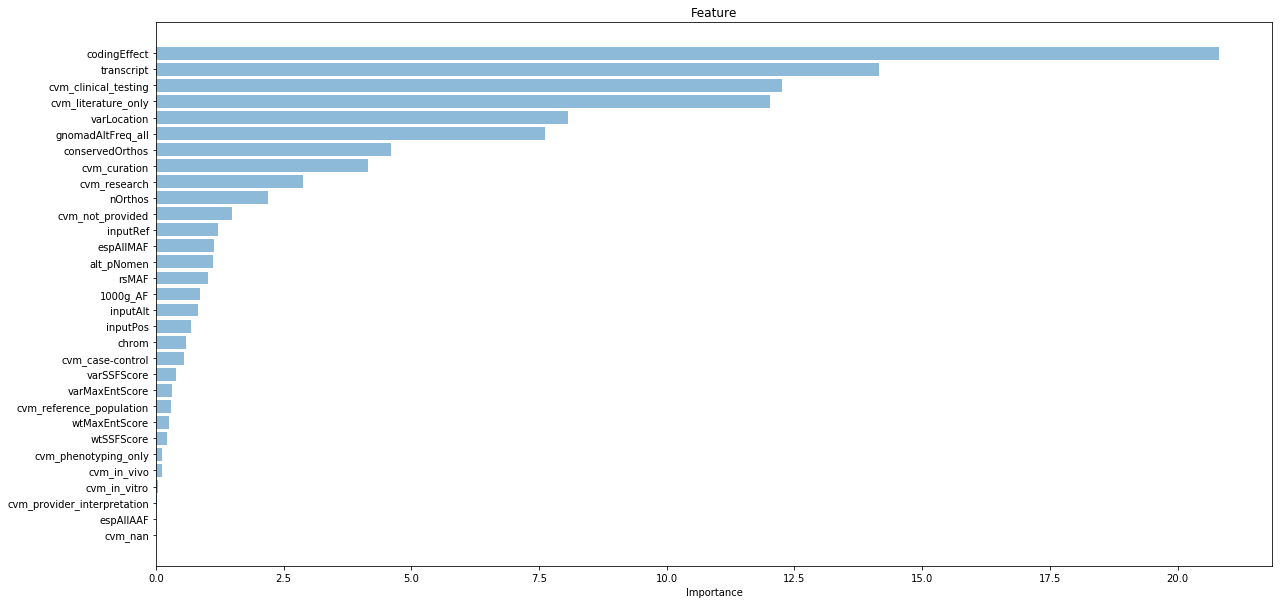

In [22]:
draw_importance(X_train.columns, model.feature_importances_)

In [23]:
model.get_params()

{'loss_function': 'Logloss'}